**Data Mining Group 4 Jupyter Notebook**

By: Assaf Bohen, Adrian Nica, TJ Jablonski

In [1]:
import requests
import zipfile
import io
import pandas as pd
from urllib.parse import urlparse
import os

def download_and_extract_csv(zip_url):
    """
    Downloads a ZIP file from `zip_url`, extracts the first .csv file found,
    and returns it as a Pandas DataFrame.
    """
    #determines if zip is found
    response = requests.get(zip_url)
    if response.status_code == 200:
        zip_content = io.BytesIO(response.content)
        
        #extract csv files
        with zipfile.ZipFile(zip_content, 'r') as zip_ref:
            for file_name in zip_ref.namelist():
                if file_name.endswith('.csv'):
                    with zip_ref.open(file_name) as csv_file:
                        df = pd.read_csv(csv_file)

                        #print success
                        parsed_url = urlparse(zip_url)
                        print(f'Successfully extracted {file_name} from {os.path.basename(parsed_url.path)}')
                        return df

        #no csv files found
        return None
    else:
        print(f"Failed to retrieve ZIP from {zip_url}")
        return None

In [2]:
#urls to zip files
csv_url_2024 = "https://cdn.sanity.io/files/jo7n4k8s/production/262f04c41d99fea692e0125c342e446782233fe4.zip/stack-overflow-developer-survey-2024.zip"
csv_url_2023 = "https://cdn.stackoverflow.co/files/jo7n4k8s/production/49915bfd46d0902c3564fd9a06b509d08a20488c.zip/stack-overflow-developer-survey-2023.zip"
csv_url_2022 = "https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-2022.zip"

#download csv files
odf_2024 = download_and_extract_csv(csv_url_2024)
odf_2023 = download_and_extract_csv(csv_url_2023)
odf_2022 = download_and_extract_csv(csv_url_2022)

Successfully extracted survey_results_public.csv from stack-overflow-developer-survey-2024.zip
Successfully extracted survey_results_public.csv from stack-overflow-developer-survey-2023.zip
Successfully extracted survey_results_public.csv from stack-overflow-developer-survey-2022.zip


In [3]:
#converts column names to uppercase and removes spacing
odf_2024.columns = odf_2024.columns.str.upper().str.replace(" ", "")
odf_2023.columns = odf_2023.columns.str.upper().str.replace(" ", "")
odf_2022.columns = odf_2022.columns.str.upper().str.replace(" ", "")

#prints all rows
with pd.option_context('display.max_columns', None,
                       'display.max_rows', None,
                       'display.width', 6000):
    print(odf_2024.head())

   RESPONSEID                      MAINBRANCH                 AGE           EMPLOYMENT REMOTEWORK   CHECK                                   CODINGACTIVITIES                                            EDLEVEL                                          LEARNCODE                                    LEARNCODEONLINE                                            TECHDOC YEARSCODE YEARSCODEPRO                DEVTYPE ORGSIZE PURCHASEINFLUENCE BUYNEWTOOL BUILDVSBUY TECHENDORSE                                            COUNTRY CURRENCY  COMPTOTAL                             LANGUAGEHAVEWORKEDWITH                             LANGUAGEWANTTOWORKWITH                                    LANGUAGEADMIRED           DATABASEHAVEWORKEDWITH      DATABASEWANTTOWORKWITH             DATABASEADMIRED                    PLATFORMHAVEWORKEDWITH                    PLATFORMWANTTOWORKWITH                           PLATFORMADMIRED                  WEBFRAMEHAVEWORKEDWITH            WEBFRAMEWANTTOWORKWITH               WEBFRA

In [4]:
#drop all cols from odf_2024 that didn't select Apples (only survey to check for bots)
print(f'odf_2024 rows before dropping bots: {odf_2024.shape[0]}')
odf_2024 = odf_2024[odf_2024['CHECK'] == 'Apples']
print(f'odf_2024 rows after dropping bots: {odf_2024.shape[0]}\n')

#finds common column names across all dfs
common_cols = set(odf_2024.columns).intersection(odf_2023.columns).intersection(odf_2022.columns)

#creates copies of dfs
df_2024 = odf_2024[list(common_cols)].copy()
df_2023 = odf_2023[list(common_cols)].copy()
df_2022 = odf_2022[list(common_cols)].copy()

#adds a year column to all dfs
df_2024["year"] = 2024
df_2023["year"] = 2023
df_2022["year"] = 2022

#combined the common columns of the dfs
combined_df = pd.concat([df_2024, df_2023, df_2022], ignore_index=True)

#prints shape and all rows
print(f"Combined DataFrame shape: {combined_df.shape}")
with pd.option_context('display.max_columns', None,
                       'display.max_rows', None,
                       'display.width', 6000):
    print(combined_df.head())

odf_2024 rows before dropping bots: 65437
odf_2024 rows after dropping bots: 65437

Combined DataFrame shape: (227889, 63)
  OPSYSPROFESSIONALUSE OFFICESTACKSYNCWANTTOWORKWITH                  WEBFRAMEHAVEWORKEDWITH TIMESEARCHING                                         NEWSOSITES TBRANCH                             LANGUAGEWANTTOWORKWITH YEARSCODEPRO PURCHASEINFLUENCE  CONVERTEDCOMPYEARLY                                          LEARNCODE                    PLATFORMWANTTOWORKWITH           SOCOMM BUYNEWTOOL  COMPTOTAL           DATABASEHAVEWORKEDWITH           SURVEYLENGTH REMOTEWORK                             LANGUAGEHAVEWORKEDWITH                                   CODINGACTIVITIES                                            COUNTRY KNOWLEDGE_7                 KNOWLEDGE_6                                    LEARNCODEONLINE                      TOOLSTECHWANTTOWORKWITH SOACCOUNT                           MISCTECHHAVEWORKEDWITH             SOVISITFREQ KNOWLEDGE_5         OPSYSPERSONALUSE 

-------------------------------------------------------------------------------------                       
.

**Compensation Data Exploration**

.

-------------------------------------------------------------------------------------

In [ ]:
#show changes
print(f'Number of columns in compensation_df: {combined_df.shape[1]}')

#columns to include in compensatiion_df
compensation_include_columns = [
    'CONVERTEDCOMPYEARLY',
    'COUNTRY',
    'DEVTYPE',
    'EDLEVEL',
    'YEARSCODE',
    'YEARSCODEPRO',
    'ORGSIZE'
]

#creates jobsat_df
compensation_df = combined_df[compensation_include_columns]

#show changes
print(f'Number of columns in compensation_df: {compensation_df.shape[1]}')
compensation_df.head(3)

Number of columns in compensation_df: 63
Number of columns in compensation_df: 7


,CONVERTEDCOMPYEARLY,COUNTRY,DEVTYPE,EDLEVEL,YEARSCODE,YEARSCODEPRO,ORGSIZE
0,NaN,United States of America,NaN,Primary/elementary school,NaN,NaN,NaN
1,NaN,United Kingdom of Great Britain and Northern I...,"Developer, full-stack","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20,17,NaN
2,NaN,United Kingdom of Great Britain and Northern I...,Developer Experience,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",37,27,NaN
3,NaN,Canada,"Developer, full-stack",Some college/university study without earning ...,4,NaN,NaN
4,NaN,Norway,"Developer, full-stack","Secondary school (e.g. American high school, G...",9,NaN,NaN


**Cleaning**

In [6]:
#drop all NaN values in CONVERTEDCOMPYEARLY column
print(f'Rows before dropping NaN CCY values: {compensation_df.shape[0]}')
compensation_df = compensation_df.dropna(subset=['CONVERTEDCOMPYEARLY'])
print(f'Rows after dropping NaN CCY values: {compensation_df.shape[0]}\n')

#drop all remaining NaN values
print(f'Rows before dropping all remaining NaN values: {compensation_df.shape[0]}')
compensation_df = compensation_df.dropna()
print(f'Rows after dropping all remaining NaN values: {compensation_df.shape[0]}\n')

#ensure no more NaN
if sum(compensation_df.isna().sum()) == 0:
    print('All NaN values successfully removed')
else:
    print('Error: Dataset still contains NaN values')

#reset index
compensation_df = compensation_df.reset_index(drop=True)

Rows before dropping NaN CCY values: 227889
Rows after dropping NaN CCY values: 109525

Rows before dropping all remaining NaN values: 109525
Rows after dropping all remaining NaN values: 108753

All NaN values successfully removed



In [15]:
#manually ordinal encode
orgsize_order = {
    
}

CONVERTEDCOMPYEARLY    float64
COUNTRY                 object
DEVTYPE                 object
EDLEVEL                 object
YEARSCODE               object
YEARSCODEPRO            object
ORGSIZE                 object
dtype: object

Text(0, 0.5, 'Count')

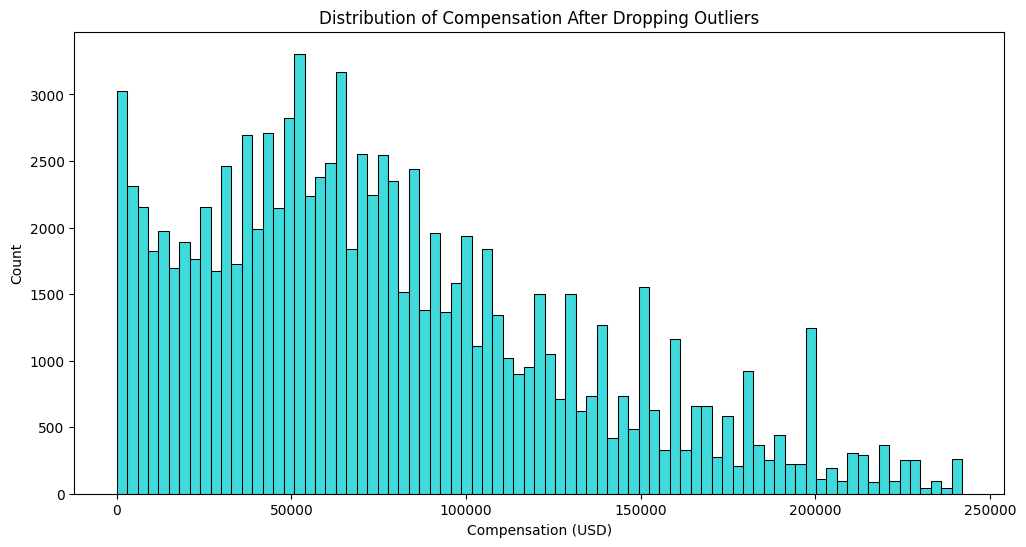

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

#drop outliers based on 1.5*IQR
Q1 = compensation_df['CONVERTEDCOMPYEARLY'].quantile(0.25)
Q3 = compensation_df['CONVERTEDCOMPYEARLY'].quantile(0.75)
IQR = Q3 - Q1
compensation_df = compensation_df[
    (compensation_df['CONVERTEDCOMPYEARLY'] >= Q1 - 1.5 * IQR) &
    (compensation_df['CONVERTEDCOMPYEARLY'] <= Q3 + 1.5 * IQR)
]

#plot w/out outliers
plt.figure(figsize=(12, 6))
sns.histplot(x=compensation_df['CONVERTEDCOMPYEARLY'], color='darkturquoise')
plt.title('Distribution of Compensation After Dropping Outliers')
plt.xlabel('Compensation (USD)')
plt.ylabel('Count')

-------------------------------------------------------------------------------------                       

.

**Job Satisfaction Data Exploration**

.

-------------------------------------------------------------------------------------

In [10]:
#show changes
print(f'Number of columns in odf_2024: {odf_2024.shape[1]}')

#columns to include in jobsat_df
jobsat_include_columns = [
    'JOBSAT',
    'JOBSATPOINTS_1', #drives team strategy
    'JOBSATPOINTS_4', #contributes to open source
    'JOBSATPOINTS_5', #secures data and environments
    'JOBSATPOINTS_6', #improves code and dev environments
    'JOBSATPOINTS_7', #learns and uses new technologies
    'JOBSATPOINTS_8', #designs and builds architecture and databases
    'JOBSATPOINTS_9', #expert that others rely on for tools/languages/processes
    'JOBSATPOINTS_10', #works with new or top-tier hardware
    'JOBSATPOINTS_11', #uses a well-supported internal network for easy observability
    'KNOWLEDGE_1', #interacts with people outside immediate team
    'KNOWLEDGE_2', #knowledge silos make it hard to share ideas across org
    'KNOWLEDGE_3', #can find up-to-date info to do job effectively
    'KNOWLEDGE_4', #quickly finds answers using current tools/resources
    'KNOWLEDGE_5', #knows which system/resource to use for questions
    'KNOWLEDGE_6', #often repeats answers to the same questions
    'KNOWLEDGE_7', #delays in getting answers interrupt workflow
    'KNOWLEDGE_8', #feels equipped to work across the company's code/platform
    'KNOWLEDGE_9', #has requested employer reimbursement for helpful tools
    'FREQUENCY_1', #frequency of needing help from people outside the team
    'FREQUENCY_2', #frequency of interacting with people outside the team
    'FREQUENCY_3', #frequency of encountering knowledge silos at work
    'YEARSCODE', #coding experience including education
    'WORKEXP', #total years of work experience
    'FRUSTRATION', #challenges that cause most frustration (10 total)
    'REMOTEWORK', #work situation: Remote, in-person, remote
    'TIMESEARCHING', #time spent search for an answer
    'TIMEANSWERING' #time spent answering questions
]

#creates jobsat_df
jobsat_df = odf_2024[jobsat_include_columns]

#show changes
print(f'Number of columns in jobsat_df: {jobsat_df.shape[1]}')
jobsat_df.head()

Number of columns in odf_2024: 114
Number of columns in jobsat_df: 28


,JOBSAT,JOBSATPOINTS_1,JOBSATPOINTS_4,JOBSATPOINTS_5,JOBSATPOINTS_6,JOBSATPOINTS_7,JOBSATPOINTS_8,JOBSATPOINTS_9,JOBSATPOINTS_10,JOBSATPOINTS_11,...,KNOWLEDGE_9,FREQUENCY_1,FREQUENCY_2,FREQUENCY_3,YEARSCODE,WORKEXP,FRUSTRATION,REMOTEWORK,TIMESEARCHING,TIMEANSWERING
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Remote,NaN,NaN
1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Agree,NaN,NaN,NaN,20,17.0,NaN,Remote,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,37,NaN,NaN,Remote,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN


**Cleaning**

In [11]:
#drop all NaN values in JOBSAT column
print(f'Rows before dropping NaN JOBSAT values: {jobsat_df.shape[0]}')
jobsat_df = jobsat_df.dropna(subset=['JOBSAT'])
print(f'Rows after dropping NaN JOBSAT values: {jobsat_df.shape[0]}\n')

# #determines how many rows would be dropped if all NaN are dropped
# determine_drop_all = jobsat_df.copy()
# determine_drop_all = determine_drop_all.dropna()
# #shows changes
# print(f'Rows before dropping all NaN values: {jobsat_df.shape[0]}')
# print(f'Rows after dropping all NaN values: {determine_drop_all.shape[0]}')

#---only 13.5% data lost when all remaining NaNs dropped, so will just drop all remainingNaN---#
print(f'Rows before dropping all remaining NaN values: {jobsat_df.shape[0]}')
jobsat_df = jobsat_df.dropna()
print(f'Rows after dropping all remaining NaN values: {jobsat_df.shape[0]}\n')

#ensure no more NaN
if sum(compensation_df.isna().sum()) == 0:
    print('All NaN values successfully removed')
else:
    print('Error: Dataset still contains NaN values')

#reset index
jobsat_df = jobsat_df.reset_index(drop=True)

Rows before dropping NaN JOBSAT values: 65437
Rows after dropping NaN JOBSAT values: 29126

Rows before dropping all remaining NaN values: 29126
Rows after dropping all remaining NaN values: 25213

All NaN values successfully removed


In [12]:
#manually encode all the ordinal features
knowledge_order = {
    'Strongly agree': 4, 
    'Agree': 3,
    'Neither agree nor disagree': 2,
    'Disagree': 1,
    'Strongly disagree': 0
}
for i in range(1, 10): 
    jobsat_df['KNOWLEDGE_'+str(i)] = jobsat_df['KNOWLEDGE_'+str(i)].map(knowledge_order)

frequency_order = {
    'Never': 0, 
    '1-2 times a week': 1,
    '3-5 times a week': 2, 
    '6-10 times a week': 3, 
    '10+ times a week': 4
}
for i in range(1,4): 
    jobsat_df['FREQUENCY_'+str(i)] = jobsat_df['FREQUENCY_'+str(i)].map(frequency_order)

time_spent_order = {
    '15-30 minutes a day' : 0,
    '30-60 minutes a day' : 1,
    'Less than 15 minutes a day' : 2,
    '60-120 minutes a day' : 3,
    'Over 120 minutes a day' : 4
}
jobsat_df['TIMESEARCHING'] = jobsat_df['TIMESEARCHING'].map(time_spent_order)
jobsat_df['TIMEANSWERING'] = jobsat_df['TIMEANSWERING'].map(time_spent_order)

#get dummies for FRUSTRATIONS and REMOTEWORK column
frustration_dummies = jobsat_df['FRUSTRATION'].str.get_dummies(sep=';')
remote_dummies = pd.get_dummies(jobsat_df['REMOTEWORK']).astype(int)

#add to jobsat_df
jobsat_df = pd.concat([jobsat_df, frustration_dummies], axis=1)
jobsat_df = pd.concat([jobsat_df, remote_dummies], axis=1)

#drop old columns
jobsat_df = jobsat_df.drop(columns=['FRUSTRATION', 'REMOTEWORK'])

#get float columns and convert to int
float_cols = jobsat_df.select_dtypes(include='float').columns
jobsat_df[float_cols] = jobsat_df[float_cols].astype(int)

#convert YEARSCODE to int
jobsat_df['YEARSCODE'] = jobsat_df['YEARSCODE'].replace({
    'More than 50 years': '50',
    'Less than 1 year': '1'
})
jobsat_df['YEARSCODE'] = jobsat_df['YEARSCODE'].astype(int)

#rename columns
jobsat_df = jobsat_df.rename(columns={
    'WORKEXP' : 'YEARSWORKED',
    'Complexity of tech stack for build' : 'FRUSTRATION_1',
    'Complexity of tech stack for deployment' : 'FRUSTRATION_2',
    'Amount of technical debt' : 'FRUSTRATION_3',
    'Number of software tools in use' : 'FRUSTRATION_4',
    'Patching/updating core components' : 'FRUSTRATION_5',
    'Maintaining security of code being produced' : 'FRUSTRATION_6',
    'Maintaining security of systems/platforms used in work' : 'FRUSTRATION_7',
    'Reliability of tools/systems used in work' : 'FRUSTRATION_8',
    'Tracking my work' : 'FRUSTRATION_9',
    'Showing my contributions' : 'FRUSTRATION_10',
    'None of these' : 'FRUSTRATION_11',
    'Hybrid (some remote, some in-person)' : 'HYBRID',
    'In-person' : 'IN-PERSON',
    'Remote' : 'REMOTE'
})

pd.set_option('display.max_columns', None)
print(jobsat_df.shape)
jobsat_df.head()

(25213, 40)


,JOBSAT,JOBSATPOINTS_1,JOBSATPOINTS_4,JOBSATPOINTS_5,JOBSATPOINTS_6,JOBSATPOINTS_7,JOBSATPOINTS_8,JOBSATPOINTS_9,JOBSATPOINTS_10,JOBSATPOINTS_11,KNOWLEDGE_1,KNOWLEDGE_2,KNOWLEDGE_3,KNOWLEDGE_4,KNOWLEDGE_5,KNOWLEDGE_6,KNOWLEDGE_7,KNOWLEDGE_8,KNOWLEDGE_9,FREQUENCY_1,FREQUENCY_2,FREQUENCY_3,YEARSCODE,YEARSWORKED,TIMESEARCHING,TIMEANSWERING,FRUSTRATION_3,FRUSTRATION_1,FRUSTRATION_2,FRUSTRATION_6,FRUSTRATION_7,FRUSTRATION_11,FRUSTRATION_4,FRUSTRATION_5,FRUSTRATION_8,FRUSTRATION_10,FRUSTRATION_9,HYBRID,IN-PERSON,REMOTE
0,8,50,0,0,25,10,0,15,0,0,4,3,4,3,3,4,3,2,2,2,3,3,20,15,1,3,1,0,0,0,0,0,1,0,0,1,1,0,0,1
1,8,0,0,30,30,0,0,20,10,10,4,1,2,3,3,0,3,3,0,1,1,1,20,12,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
2,5,0,0,0,0,0,0,0,0,0,4,2,3,1,2,3,3,2,0,1,2,1,31,29,3,3,1,1,1,1,0,0,0,0,0,0,0,1,0,0
3,10,10,0,10,60,10,10,0,0,0,3,3,2,3,4,3,1,3,2,0,2,2,12,12,0,1,1,1,0,0,1,0,0,1,1,0,1,1,0,0
4,6,90,100,100,100,90,90,100,90,100,4,2,2,3,4,3,4,3,4,0,4,3,5,10,2,0,0,1,0,0,0,0,1,0,0,1,1,1,0,0


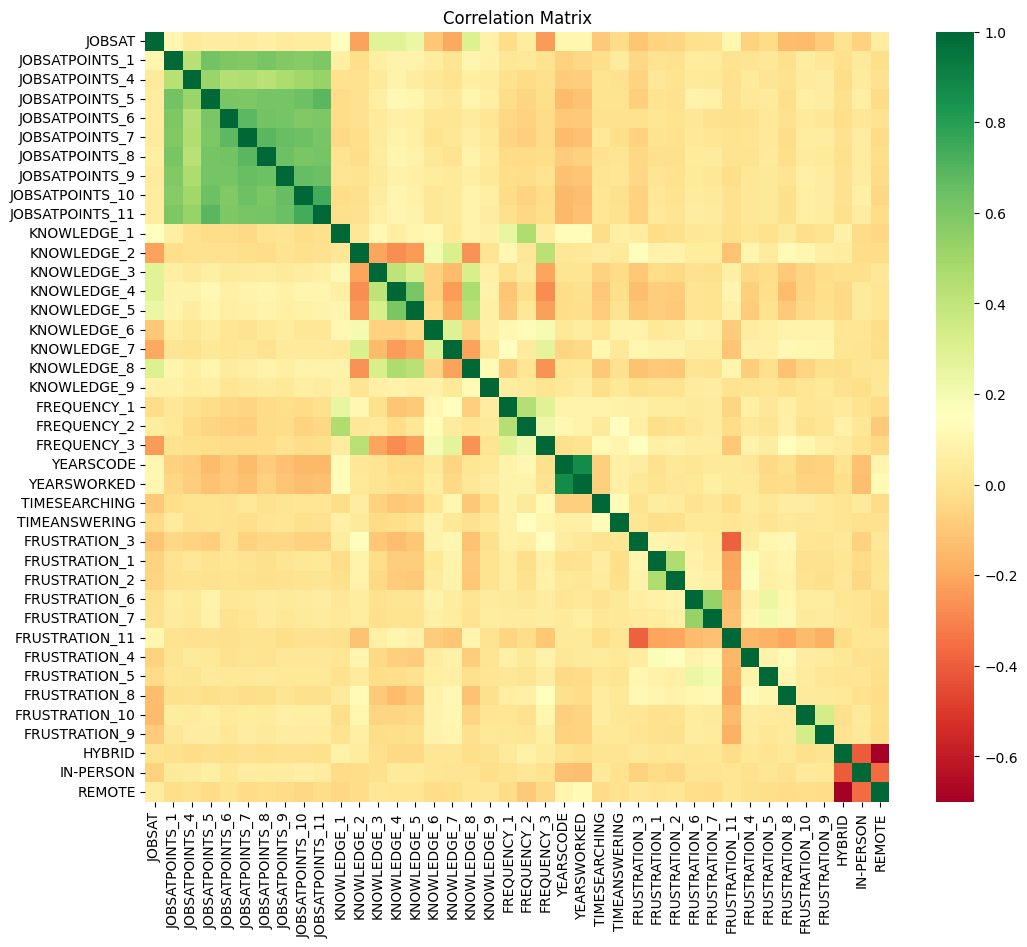

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(jobsat_df.corr(), cmap='RdYlGn')
plt.title('Correlation Matrix')
plt.show()

In [14]:
#correlation matrix
jobsat_corr = jobsat_df.corr()['JOBSAT'].abs().sort_values(ascending=False)
jobsat_corr.head(15)

JOBSAT            1.000000
KNOWLEDGE_8       0.297007
KNOWLEDGE_3       0.282274
KNOWLEDGE_4       0.280602
FREQUENCY_3       0.238412
KNOWLEDGE_5       0.234640
KNOWLEDGE_2       0.220203
KNOWLEDGE_7       0.197609
KNOWLEDGE_1       0.148901
FRUSTRATION_10    0.147535
FRUSTRATION_8     0.138509
FRUSTRATION_3     0.111080
KNOWLEDGE_6       0.104809
YEARSCODE         0.100469
FRUSTRATION_11    0.099804
Name: JOBSAT, dtype: float64